<img src='image.jpg'/>

# Intel: Image Classification

## Problem Statement

You are provided with a dataset of ~25k images from a wide range of natural scenes from all around the world.
Your task is to identify which kind of scene can the image be categorized into.

<img src ="Dataclass.png"/>

## Source / useful links 

Data Hack: https://datahack.analyticsvidhya.com/contest/practice-problem-intel-scene-classification-challe/  <br>
Kaggle : https://www.kaggle.com/puneet6060/intel-image-classification

## Dataset Overview

This Data contains around 25k images of size 150x150 distributed under 6 categories.     
{'buildings' -> 0,      
'forest' -> 1,     
'glacier' -> 2,     
'mountain' -> 3,    
'sea' -> 4,     
'street' -> 5 }    

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.
This data was initially published on https://datahack.analyticsvidhya.com by Intel to host a Image classification Challenge.

## Approach

* Building and training a VGG16 that can classify above mentioned categories of images correctly.

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

## Dictionary mapping for labels

In [2]:
class_names = ['mountain','street','glacier','buildings','sea','forest']
class_names_label = {class_name : i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150,150)

In [3]:
class_names_label

{'mountain': 0,
 'street': 1,
 'glacier': 2,
 'buildings': 3,
 'sea': 4,
 'forest': 5}

## Loading Data

In [4]:
## Function definition
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['./intel-image-classification/seg_train/seg_train','./intel-image-classification/seg_test/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            curr_label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in os.listdir(os.path.join(dataset, folder)):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                curr_img = cv2.imread(img_path)
                curr_img = cv2.resize(curr_img, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(curr_img)
                labels.append(curr_label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

## Function Call
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading ./intel-image-classification/seg_train/seg_train
Loading ./intel-image-classification/seg_test/seg_test


## Scaling and shuffeling data

In [5]:
train_images = train_images / 255.0 
test_images  = test_images / 255.0
print('hi')
train_images, train_labels = shuffle(train_images, train_labels)


hi


## Plotting sample images

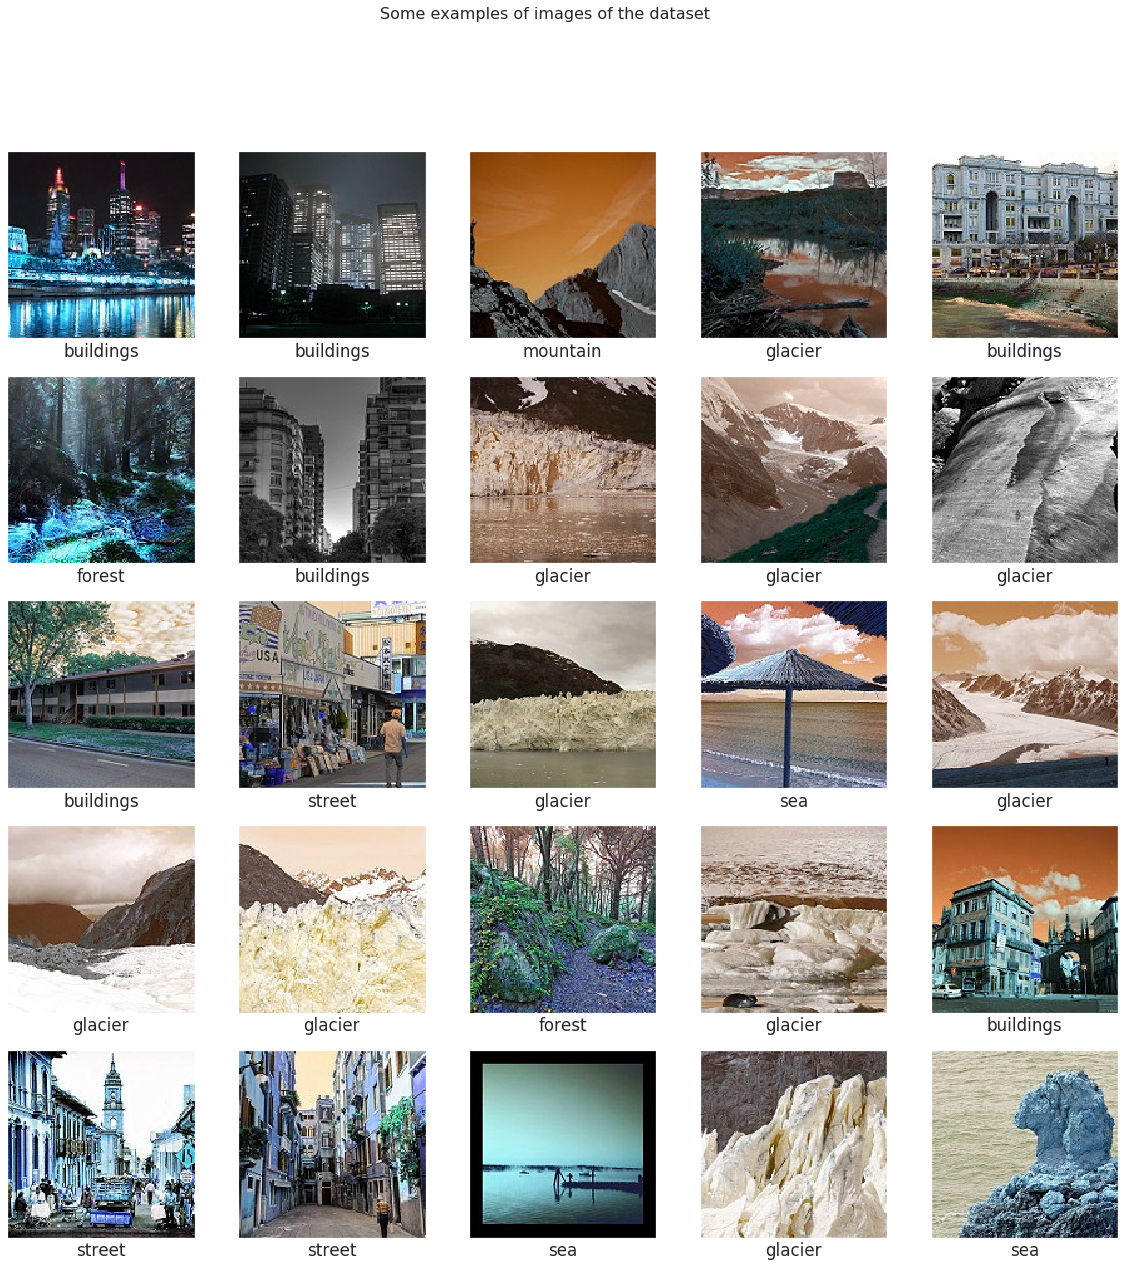

In [6]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(20,20))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
    plt.show()

    ## Function call
display_examples(class_names, train_images, train_labels)

## Preparing target

In [9]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(train_labels, 6)
y_test = np_utils.to_categorical(test_labels, 6)

Using TensorFlow backend.


## Transfer Learning using VGG16

In [11]:
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten, BatchNormalization, Dropout, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,input_shape=(150,150,3))
## Disabling training from VGG layers
vgg_conv.trainable=False

## Instantiating model
vgg_conv.trainable=False
transfer_model = Sequential()
transfer_model.add(vgg_conv)
transfer_model.add(Flatten())
transfer_model.add(Dropout(0.25))
transfer_model.add(Dense(64, activation='relu'))
transfer_model.add(Dropout(0.25))
transfer_model.add(Dense(6, activation='softmax'))


## Model summary
transfer_model.summary()

58892288/58889256 [==============================] - 95s 2us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                524352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 15,239,430
Trainable params: 524,742
Non

## Compiling model

In [12]:
optimizer = Adam(lr = 0.2e-3,beta_1 = 0.9,beta_2 = 0.999,amsgrad = False)

transfer_model.compile(optimizer,loss = 'binary_crossentropy',metrics = ["accuracy"])


## Model training with real time data augmentation

In [14]:
train_gen = ImageDataGenerator(
            rotation_range = 40,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            fill_mode = 'nearest')

history = transfer_model.fit_generator(train_gen.flow(train_images,y_train,batch_size = 32),
                                                      steps_per_epoch = len(train_images)/32,
                                                      epochs = 3,validation_data = (test_images,y_test)
                                                                                    
                                        )

Epoch 1/3
439/438 [==============================] - 2051s 5s/step - loss: 0.2289 - accuracy: 0.9041 - val_loss: 0.1300 - val_accuracy: 0.9501
Epoch 2/3
439/438 [==============================] - 2057s 5s/step - loss: 0.1712 - accuracy: 0.9317 - val_loss: 0.1198 - val_accuracy: 0.9543
Epoch 3/3
439/438 [==============================] - 2047s 5s/step - loss: 0.1593 - accuracy: 0.9357 - val_loss: 0.1133 - val_accuracy: 0.9562


## Accuracy

After the three epoch we get the accuracy of 95.62%.